In [2]:
from mpi4py import MPI
import gmsh
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
from dolfinx import plot

# 1) Load MRST data (Pa) with header x,y,pressure
# data = np.loadtxt("pressure_field_lagrange_example1.csv", delimiter=",", skiprows=1)
# x_mrst, y_mrst, p_mrst = data[:, 0], data[:, 1], data[:, 2]

# --- before the refinement loop (rank 0 only collects) ---
h_list, L2_list, L2_fem_list, rL2_list, rL2s_fem_list, H1s_list, rH1s_list = [], [], [], [], [], [], []
L2_fem_list_pf, rL2s_fem_list_pf, H1s_list_pf, rH1s_list_pf = [], [], [], []
L2_fem_list_lmbd, rL2s_fem_list_lmbd, H1s_list_lmbd, rH1s_list_lmbd = [], [], [], []

plotter = pv.Plotter(shape=(2, 4), window_size=(2000, 1000))
N_ref = 9

Lx, Ly = 1.0, 1.0
y_start, y_end = 0.0, 1.0
x_start, x_end = 0.25, 0.75


In [ ]:
#MESH GENERATION
for ref in range(N_ref+1):
    # Initialize gmsh
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 0)
    gmsh.model.add("rect_with_partial_interface")

    if MPI.COMM_WORLD.rank == 0:
        # --------------------------
        # Parameters
        # --------------------------

        lc = 1.0/ (2**ref)          # mesh size
        h = lc

        gmsh.option.setNumber("Mesh.MeshSizeMin", h)
        gmsh.option.setNumber("Mesh.MeshSizeMax", h)
        gmsh.option.setNumber("Mesh.SaveAll", 1)   # <-- add this before meshing
        # lc = 0.3
        order = 1          # element order

        # --------------------------
        # 1. Define rectangular domain Ω
        # --------------------------
        p1 = gmsh.model.occ.addPoint(0, 0, 0)
        p2 = gmsh.model.occ.addPoint(Lx, 0, 0)
        p3 = gmsh.model.occ.addPoint(Lx, Ly, 0)
        p4 = gmsh.model.occ.addPoint(0, Ly, 0)
        l1 = gmsh.model.occ.addLine(p1, p2)
        l2 = gmsh.model.occ.addLine(p2, p3)
        l3 = gmsh.model.occ.addLine(p3, p4)
        l4 = gmsh.model.occ.addLine(p4, p1)
        loop = gmsh.model.occ.addCurveLoop([l1, l2, l3, l4])
        surf = gmsh.model.occ.addPlaneSurface([loop])

        # --------------------------
        # 2. Add an internal partial horizontal line Γ
        # --------------------------
        p5 = gmsh.model.occ.addPoint(x_start, y_start, 0)
        p6 = gmsh.model.occ.addPoint(x_end, y_end, 0)
        l5 = gmsh.model.occ.addLine(p5, p6)

        # --------------------------
        # 3. Fragment the surface with the internal line (split mesh)
        # --------------------------
        gmsh.model.occ.fragment([(2, surf)], [(1, l5)])
        gmsh.model.occ.synchronize()

        # --------------------------
        # 4. Define physical groups
        # --------------------------
        # Surface (bulk Ω)
        # gmsh.model.addPhysicalGroup(2, [surf], 1)
        # gmsh.model.setPhysicalName(2, 1, "Omega")
        omega = [t for (d, t) in gmsh.model.getEntities(2)]
        gmsh.model.addPhysicalGroup(2, omega, 1)
        gmsh.model.setPhysicalName(2, 1, "Omega")

        # Identify the internal line (Γ)
        # 2) Recompute ALL post-fragment edges from surface boundaries
        from collections import Counter

        all_edges = []
        for s in omega:
            # boundary curves of each surface
            b = gmsh.model.getBoundary([(2, s)], oriented=False, recursive=False)
            all_edges.extend([t for (d, t) in b])

        counts = Counter(all_edges)

        # Outer boundary edges (belong to exactly one surface)
        boundary_curves = [t for t, c in counts.items() if c == 1]

        if boundary_curves:
            pgB = gmsh.model.addPhysicalGroup(1, boundary_curves, 3)   # id=3 for Boundary
            gmsh.model.setPhysicalName(1, pgB, "Boundary")

        # 3) Gamma = all 1D curves that are NOT in Boundary
        all_1d = [t for (d, t) in gmsh.model.getEntities(1)]
        boundary_1d = set(gmsh.model.getEntitiesForPhysicalGroup(1, 3))  # id=3
        gamma_curves = [t for t in all_1d if t not in boundary_1d]

        if gamma_curves:
            gmsh.model.addPhysicalGroup(1, gamma_curves, 2)   # id=2 for Gamma
            gmsh.model.setPhysicalName(1, 2, "Gamma")

        # --------------------------
        # 5. Generate and save mesh
        # --------------------------
        # print("Physical groups (dim, tag):", gmsh.model.getPhysicalGroups())
        # print("Gamma curves:", gmsh.model.getEntitiesForPhysicalGroup(1, 2))

        gmsh.model.mesh.generate(2)
        gmsh.model.mesh.setOrder(order)
        filename = f"diagonal_fracture_ex1_{ref}.msh"
        gmsh.write(filename)
    gmsh.finalize()

In [3]:
#REFERENCE SOLUTION
from dolfinx import mesh, fem
import ufl
import numpy as np

# ---------------------------------------------------------------------
# 1. Mesh and interface tags (similar to Γ tagging in the workshop)
# ---------------------------------------------------------------------
# Load Gmsh mesh (2D bulk Ω + 1D interface Γ)
from dolfinx.io import gmsh as gmshio
ref = N_ref
filename = f"diagonal_fracture_ex1_{ref}.msh"
msh, cell_markers, facet_markers = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=2)[0:3]

tdim = msh.topology.dim  # 2
fdim = tdim - 1             # 1

lc = 1.0/ (2**ref)          # mesh size
h = lc

# Find all facets tagged as Gamma (tag=2)
omega = msh
gamma_entities = facet_markers.find(2)

# Create a submesh for Γ (same as gamma in the JSDokken example)
gamma, gamma_to_omega = mesh.create_submesh(omega, fdim, gamma_entities)[0:2]

# Define interface tag ID (as defined in Gmsh)
Gamma_tag = 2  # <-- replace with your actual tag ID for the interface Γ

# ---------------------------------------------------------------------
# 2. Function spaces
# ---------------------------------------------------------------------
order = 2
V_m = fem.functionspace(omega, ("Lagrange", order))  # bulk Ω
V_f = fem.functionspace(gamma, ("Lagrange", order))   # interface Γ
V_l = fem.functionspace(gamma, ("Lagrange", order))   # multiplier space on Γ
W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

# ---------------------------------------------------------------------
# 3. Trial and Test functions
# ---------------------------------------------------------------------
phi, psi, mu = ufl.TestFunctions(W)
dp_m, dp_f, dl = ufl.TrialFunctions(W)
p_m = fem.Function(V_m, name="p_m")
p_f = fem.Function(V_f, name="p_f")
lmbd = fem.Function(V_l, name="lmbd")

# ---------------------------------------------------------------------
# 4. Spatial coordinates and given data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(msh)
f_m = fem.Constant(msh, 0.0)
f_f = fem.Constant(msh, 0.0)

k_m = fem.Constant(omega, 1.0)
k_f = fem.Constant(gamma, 10.0)

dx = ufl.Measure("dx", domain=omega)
dS_omega = ufl.Measure("dS", domain=omega)   # interior facets of omega
# ds = dS_omega(Gamma_tag)
# ds = ufl.Measure("ds", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)
ds = ufl.Measure("ds", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag) #Gamma is interior boundary
dx_f = ufl.Measure("dx", domain=gamma)

# Compute bounding box to locate sides
coords = omega.geometry.x
xx = coords[:, 0]
yy = coords[:, 1]

xmin, xmax = xx.min(), xx.max()
ymin, ymax = yy.min(), yy.max()

# Tolerance for side detection
tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# Locate boundary facets for bottom (y = ymin) and top (y = ymax)
bottom_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymin, atol=tol)
)
top_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymax, atol=tol)
)

# Give them integer tags: 1 = bottom, 2 = top
indices = np.concatenate([bottom_facets, top_facets]).astype(np.int32)
values = np.concatenate([
    np.full(bottom_facets.shape, 10, dtype=np.int32),  # bottom tag = 1
    np.full(top_facets.shape,    20, dtype=np.int32),  # top tag    = 2
])

neumann_tags = mesh.meshtags(omega, fdim, indices, values)

# Boundary measure for these Neumann parts
dsN = ufl.Measure("ds", domain=omega)
# dsN = ufl.Measure("ds", domain=omega, subdomain_data=neumann_tags)
# ds_Omega = ufl.Measure("ds", domain=Omega)

# Neumann data: k ∂p/∂n = g on boundary
# g_bottom = fem.Constant(omega, 2.0)   # bottom = 2
# g_top    = fem.Constant(omega, -1.0)  # top    = -1

g_N = ufl.conditional(
    ufl.lt(abs(x[1] - ymax), tol),
    -1.0,                                # top
    ufl.conditional(
        ufl.lt(abs(x[1] - ymin), tol),
        2.0,                           # bottom
        0.0                             # elsewhere
    ),
)

# ---------------------------------------------------------------------
# 5. Weak formulations
# ---------------------------------------------------------------------

# --- Bulk domain Ω ---------------------------------------------------
a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
a_m1 = -lmbd * phi * ds 
# a_m1 = -ufl.avg(lmbd) * phi * ds
a_m = a_m0 + a_m1
# L_m = f_m * phi * dx
L_m = (
    f_m * phi * dx

    # - g_bottom * phi * dsN(10)   # bottom boundary (tag 1)
    # - g_top * phi * dsN(20)      # top boundary (tag 2)
)
L_m -= g_N * phi * dsN


# --- Interface Γ -----------------------------------------------------
a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
a_f1 = lmbd * psi * ds
a_f = a_f0 + a_f1
L_f = f_f * psi * ds

# --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
a_l0 = p_m * mu * ds
a_l1 = -p_f * mu * ds
a_l = a_l0 + a_l1
L_l = fem.Constant(msh, 0.0) * mu * ds

# ---------------------------------------------------------------------
# 6. Combine interface weak form
# ---------------------------------------------------------------------
a_gamma = a_f + a_l
L_gamma = L_f + L_l

F = a_m - L_m + a_gamma - L_gamma
residual = ufl.extract_blocks(F)

jac = ufl.derivative(F, p_m, dp_m) + ufl.derivative(F, p_f, dp_f) + ufl.derivative(F, lmbd, dl)
J = ufl.extract_blocks(jac)

# Locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

# Union of all boundary dofs for which we enforce a value
# all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))
all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))

# Build a Function-valued BC so we can assign side-dependent values
p_m_bc = fem.Function(V_m)
# p_m_bc.x.array[:] = 1.0  # default 0 (bottom + right)
p_m_bc.x.array[left_dofs] = 1.0
p_m_bc.x.array[right_dofs]  = 4.0

# One BC object over the union of dofs with piecewise values
bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

# tolerance scaled to Γ
tol_g = 1e-10 * np.max(np.ptp(gamma.geometry.x, axis=0))

# locate dofs at each tip
tip1_dofs = fem.locate_dofs_geometrical(
    V_f,
    lambda x: np.logical_and(np.isclose(x[0], x_start, atol=tol_g),
                             np.isclose(x[1], y_start, atol=tol_g))
)
tip2_dofs = fem.locate_dofs_geometrical(
    V_f,
    lambda x: np.logical_and(np.isclose(x[0], x_end, atol=tol_g),
                             np.isclose(x[1], y_end, atol=tol_g))
)
# OR (ii) Different values at the two tips -> two BC objects
both_tips = np.unique(np.concatenate([tip1_dofs, tip2_dofs]))

# one Function-valued BC with piecewise values
pf_fun = fem.Function(V_f)
# pf_fun.x.array[:] = 0.0
pf_fun.x.array[tip1_dofs] = 1   # e.g. 1.0
pf_fun.x.array[tip2_dofs] = 4   # e.g. 3.0

bc_pf = fem.dirichletbc(pf_fun, both_tips)

# add it
bcs = [bc_pm, bc_pf]

print("DOFs in p_m:", p_m.function_space.dofmap.index_map.size_global)
print("DOFs in p_f:", p_f.function_space.dofmap.index_map.size_global)
print("DOFs in λ:", lmbd.function_space.dofmap.index_map.size_global)
total_dofs = (
    p_m.function_space.dofmap.index_map.size_global
    + p_f.function_space.dofmap.index_map.size_global
    + lmbd.function_space.dofmap.index_map.size_global
)
print("Total DOFs:", total_dofs)

from dolfinx.fem import petsc
entity_maps = [gamma_to_omega]

nlp = petsc.NonlinearProblem(
    residual,
    u=[p_m, p_f, lmbd],
    J=J,
    bcs=bcs,
    entity_maps=entity_maps,
    petsc_options={
        "snes_monitor": None,
        "snes_max_it": 200,  # default is 50, set your own limit
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "mat_mumps_icntl_14": 120,
        "ksp_error_if_not_converged": True,
        "snes_error_if_not_converged": True,
    },
    petsc_options_prefix="pmix_",
)
max_iterations = 25
normed_diff = 0
tol = 1e-5

nlp.solve()
iterations = nlp.solver.getIterationNumber()
print(f"Converged in {iterations} Newton iterations")

p_m_exact = p_m
p_f_exact = p_f
lmbd_exact = lmbd

Info    : Reading 'diagonal_fracture_ex1_9.msh'...
Info    : 15 entities
Info    : 304598 nodes
Info    : 609773 elements                                                                                     
Info    : Done reading 'diagonal_fracture_ex1_9.msh'                                                             
DOFs in p_m: 1216341
DOFs in p_f: 1147
DOFs in λ: 1147
Total DOFs: 1218635
  0 SNES Function norm 5.949979036443e+04
  1 SNES Function norm 9.616406349310e-10
Converged in 1 Newton iterations


In [4]:
from dolfinx.io import XDMFFile
import pathlib

outdir = pathlib.Path("result_conforming_case4")
outdir.mkdir(exist_ok=True)

from dolfinx.io import XDMFFile

# ------------------------------
# 1) Save bulk field p_m on Ω
# ------------------------------
omega_file = outdir / "omega_finest.xdmf"
with XDMFFile(omega.comm, str(omega_file), "w") as xdmf:
    xdmf.write_mesh(omega)
    xdmf.write_function(p_m_exact)

# ------------------------------
# 2) Save interface fields p_f, λ on Γ
# ------------------------------
gamma_file = outdir / "gamma_finest.xdmf"
with XDMFFile(gamma.comm, str(gamma_file), "w") as xdmf:
    xdmf.write_mesh(gamma)
    xdmf.write_function(p_f_exact)
    xdmf.write_function(lmbd_exact)

RuntimeError: Degree of output Function must be same as mesh degree. Maybe the Function needs to be interpolated?

In [3]:
from mpi4py import MPI
import numpy as np
from petsc4py import PETSc
from dolfinx import fem, geometry
import ufl

def l2_h1_errors_proj(p, p_exact, comm=MPI.COMM_WORLD):
    """
    Compare coarse solution `p` to the L2-projection of `p_exact` (defined on a fine mesh)
    onto the coarse function space of `p`. Returns (err_L2, err_H1_full, rel_L2, rel_H1_full).
    Works on recent dolfinx without QuadratureElement / ufl.FiniteElement.
    """
    Vc = p.function_space
    mesh_coarse = Vc.mesh
    mesh_fine   = p_exact.function_space.mesh
    tdim = mesh_fine.topology.dim
    gdim = mesh_coarse.geometry.dim

    # Choose a quadrature degree high enough for your coarse degree and p_exact variation
    k = Vc.ufl_element().degree
    q = 2 * k + 2
    dx = ufl.dx(domain=mesh_coarse, metadata={"quadrature_degree": q})

    # --- Build search trees on the FINE mesh (to evaluate p_exact at arbitrary points) ---
    bbt_fine = geometry.bb_tree(mesh_fine, tdim)
    mid_tree_fine = geometry.create_midpoint_tree(
        mesh_fine, tdim,
        np.arange(mesh_fine.topology.index_map(tdim).size_local, dtype=np.int32)
    )

    def eval_p_exact_on_points(x: np.ndarray) -> np.ndarray:
        """
        Evaluate p_exact (living on the FINE mesh) at physical points x (on coarse cells).
        x has shape (gdim, N); return shape (1, N) for scalar fields.
        """
        _gdim, N = x.shape
        if _gdim != gdim:
            raise ValueError(f"Point array has gdim={_gdim}, expected {gdim}")

        # dolfinx expects 3D coordinates; pad in 2D
        if gdim == 2:
            X3 = np.column_stack([x.T, np.zeros(N, dtype=np.float64)])  # (N, 3)
        elif gdim == 3:
            X3 = x.T.copy()                                             # (N, 3)
        else:
            raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

        # candidate & colliding cells on the fine mesh
        cands = geometry.compute_collisions_points(bbt_fine, X3)
        hits = geometry.compute_colliding_cells(mesh_fine, cands, X3)

        cells = np.full(N, -1, dtype=np.int32)
        for i in range(N):
            li = hits.links(i)
            if len(li) > 0:
                cells[i] = li[0]

        # fallback to nearest entity if a point sits barely outside (roundoff)
        missing = np.where(cells == -1)[0]
        if missing.size > 0:
            nearest = geometry.compute_closest_entity(bbt_fine, mid_tree_fine, mesh_fine, X3[missing])
            cells[missing] = nearest

        vals = p_exact.eval(X3, cells)   # shape (N,) for scalar field
        return np.asarray(vals, dtype=np.float64).reshape(1, N)

    # --- L2 projection: assemble M c = b with b_i = ∫ p_exact * φ_i dx  (φ_i test funcs on coarse mesh)
    u = ufl.TrialFunction(Vc)
    v = ufl.TestFunction(Vc)

    # Mass matrix on coarse space
    a = ufl.inner(u, v) * dx

    # RHS uses an Expression that evaluates p_exact at coarse quadrature points
    expr = fem.Expression(eval_p_exact_on_points)  # let dolfinx pick points from dx metadata
    # In recent dolfinx, you can pass Expression directly into a UFL form with *the same* dx metadata:
    L = ufl.inner(expr, v) * dx

    A = fem.petsc.assemble_matrix(fem.form(a))
    A.assemble()
    b = fem.petsc.assemble_vector(fem.form(L))

    p_proj = fem.Function(Vc)
    ksp = PETSc.KSP().create(comm)
    ksp.setOperators(A)
    ksp.setType(PETSc.KSP.Type.CG)
    ksp.getPC().setType(PETSc.PC.Type.JACOBI)
    ksp.setFromOptions()
    ksp.solve(b, p_proj.vector)
    p_proj.vector.assemble()

    # --- Errors of p against the L2-projected reference
    err = p - p_proj

    # ||err||_L2^2 and |err|_H1^2
    L2_sq_local = fem.assemble_scalar(fem.form(ufl.inner(err, err) * dx))
    H1_semi_sq_local = fem.assemble_scalar(fem.form(ufl.inner(ufl.grad(err), ufl.grad(err)) * dx))

    L2_sq = comm.allreduce(L2_sq_local, op=MPI.SUM)
    H1_semi_sq = comm.allreduce(H1_semi_sq_local, op=MPI.SUM)

    err_L2 = np.sqrt(L2_sq)
    err_H1_full = np.sqrt(L2_sq + H1_semi_sq)

    # Norms of the projected exact (for relative errors in the same space)
    L2_proj_sq_local = fem.assemble_scalar(fem.form(ufl.inner(p_proj, p_proj) * dx))
    H1_proj_sq_local = fem.assemble_scalar(fem.form(ufl.inner(ufl.grad(p_proj), ufl.grad(p_proj)) * dx))

    L2_proj_sq = comm.allreduce(L2_proj_sq_local, op=MPI.SUM)
    H1_proj_sq = comm.allreduce(H1_proj_sq_local, op=MPI.SUM)

    exact_L2 = np.sqrt(L2_proj_sq)
    exact_H1_full = np.sqrt(L2_proj_sq + H1_proj_sq)

    rel_L2 = (err_L2 / exact_L2) if exact_L2 > 0 else (0.0 if err_L2 == 0 else np.inf)
    rel_H1_full = (err_H1_full / exact_H1_full) if exact_H1_full > 0 else (0.0 if err_H1_full == 0 else np.inf)

    return err_L2, err_H1_full, rel_L2, rel_H1_full


In [4]:
from dolfinx import geometry
def l2_h1_errors(p, p_exact, comm=MPI.COMM_WORLD):
    mesh_fine = p_exact.function_space.mesh
    mesh_coarse = p.function_space.mesh

    tdim = mesh_fine.topology.dim

    # --- Trees on the COARSE mesh (we will evaluate p on the coarse mesh) ---
    bbt_coarse = geometry.bb_tree(mesh_coarse, tdim)
    mid_tree_coarse = geometry.create_midpoint_tree(
        mesh_coarse, tdim,
        np.arange(mesh_coarse.topology.index_map(tdim).size_local, dtype=np.int32)
    )

    # --- Allocate target on the FINE space: p_coarse sampled at fine DoF points ---
    # p_exact is defined on the fine mesh, so reuse its function space
    p_coarse_on_exact = fem.Function(p_exact.function_space)

    def eval_p_coarse_on_points(x: np.ndarray) -> np.ndarray:
        """Return coarse solution p evaluated at points x on the FINE mesh."""
        gdim, N = x.shape
        if gdim == 2:
            X3 = np.column_stack([x.T, np.zeros(N, dtype=np.float64)])  # (N, 3)
        elif gdim == 3:
            X3 = x.T.copy()                                             # (N, 3)
        else:
            raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

        # 1) candidates on COARSE mesh
        cands = geometry.compute_collisions_points(bbt_coarse, X3)
        # 2) filter to true hits
        hits = geometry.compute_colliding_cells(mesh_coarse, cands, X3)

        # 3) pick one owning cell per point
        cells = np.full(N, -1, dtype=np.int32)
        for i in range(N):
            li = hits.links(i)
            if len(li) > 0:
                cells[i] = li[0]

        # Fallback: nearest coarse cell by midpoint
        missing = np.where(cells == -1)[0]
        if missing.size > 0:
            nearest = geometry.compute_closest_entity(
                bbt_coarse, mid_tree_coarse, mesh_coarse, X3[missing]
            )
            cells[missing] = nearest

        # 4) evaluate coarse solution p at those points/cells
        vals_1d = p.eval(X3, cells)  # (N,)
        return np.asarray(vals_1d, dtype=np.float64).reshape(1, N)  # scalar -> (1, N)
        # For vector-valued fields, adapt as in your comment.

    # Interpolate coarse solution into fine space
    p_coarse_on_exact.interpolate(eval_p_coarse_on_points)

    # --- Integrate on the FINE mesh/domain ---
    dx = ufl.dx(domain=mesh_fine)
    err = p_exact - p_coarse_on_exact

    # ||err||_L2^2
    L2_sq_local = fem.assemble_scalar(fem.form(ufl.inner(err, err) * dx))
    L2_sq = comm.allreduce(L2_sq_local, op=MPI.SUM)

    # |err|_H1^2 = ||∇err||_L2^2
    H1_semi_sq_local = fem.assemble_scalar(fem.form(ufl.inner(ufl.grad(err), ufl.grad(err)) * dx))
    H1_semi_sq = comm.allreduce(H1_semi_sq_local, op=MPI.SUM)

    # Norms
    err_L2 = np.sqrt(L2_sq)
    err_H1_semi = np.sqrt(H1_semi_sq)
    err_H1_full = np.sqrt(L2_sq + H1_semi_sq)

    # --- relative errors ---
    # ||p_exact||_L2^2
    L2_exact_sq_local = fem.assemble_scalar(fem.form(ufl.inner(p_coarse_on_exact, p_coarse_on_exact) * dx))
    L2_exact_sq = comm.allreduce(L2_exact_sq_local, op=MPI.SUM)

    # |p_exact|_H1^2
    H1_semi_exact_sq_local = fem.assemble_scalar(
        fem.form(ufl.inner(ufl.grad(p_coarse_on_exact), ufl.grad(p_coarse_on_exact)) * dx)
    )
    H1_semi_exact_sq = comm.allreduce(H1_semi_exact_sq_local, op=MPI.SUM)

    # Norms of exact
    exact_L2 = np.sqrt(L2_exact_sq)
    exact_H1_semi = np.sqrt(H1_semi_exact_sq)
    exact_H1_full = np.sqrt(L2_exact_sq + H1_semi_exact_sq)

    # Relative errors with zero-denominator guard
    rel_L2 = err_L2 / exact_L2 if exact_L2 > 0 else (0.0 if err_L2 == 0 else np.inf)
    rel_H1_semi = err_H1_semi / exact_H1_semi if exact_H1_semi > 0 else (0.0 if err_H1_semi == 0 else np.inf)
    rel_H1_full = err_H1_full / exact_H1_full if exact_H1_full > 0 else (0.0 if err_H1_full == 0 else np.inf)

    return {
        "err_L2": err_L2,
        "err_H1_semi": err_H1_semi,
        "err_H1_full": err_H1_full,
        "rel_L2": rel_L2,
        "rel_H1_semi": rel_H1_semi,   # <-- often what people plot as “H1 error”
        "rel_H1_full": rel_H1_full
    }
    # return err_L2, err_H1_full

for ref in range(N_ref):
    from dolfinx import mesh, fem
    import ufl
    import numpy as np

    # ---------------------------------------------------------------------
    # 1. Mesh and interface tags (similar to Γ tagging in the workshop)
    # ---------------------------------------------------------------------
    # Load Gmsh mesh (2D bulk Ω + 1D interface Γ)
    from dolfinx.io import gmsh as gmshio
    filename = f"diagonal_fracture_ex1_{ref}.msh"
    msh, cell_markers, facet_markers = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=2)[0:3]

    tdim = msh.topology.dim  # 2
    fdim = tdim - 1             # 1

    lc = 1.0/ (2**ref)          # mesh size
    h = lc

    # Find all facets tagged as Gamma (tag=2)
    omega = msh
    gamma_entities = facet_markers.find(2)

    # Create a submesh for Γ (same as gamma in the JSDokken example)
    gamma, gamma_to_omega = mesh.create_submesh(omega, fdim, gamma_entities)[0:2]

    # Define interface tag ID (as defined in Gmsh)
    Gamma_tag = 2  # <-- replace with your actual tag ID for the interface Γ

    # ---------------------------------------------------------------------
    # 2. Function spaces
    # ---------------------------------------------------------------------
    order = 2
    V_m = fem.functionspace(omega, ("Lagrange", order))  # bulk Ω
    V_f = fem.functionspace(gamma, ("Lagrange", order))   # interface Γ
    V_l = fem.functionspace(gamma, ("Lagrange", order))   # multiplier space on Γ
    W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

    # ---------------------------------------------------------------------
    # 3. Trial and Test functions
    # ---------------------------------------------------------------------
    phi, psi, mu = ufl.TestFunctions(W)
    dp_m, dp_f, dl = ufl.TrialFunctions(W)
    p_m = fem.Function(V_m, name="p_m")
    p_f = fem.Function(V_f, name="p_f")
    lmbd = fem.Function(V_l, name="lmbd")

    # ---------------------------------------------------------------------
    # 4. Spatial coordinates and given data
    # ---------------------------------------------------------------------
    x = ufl.SpatialCoordinate(msh)
    f_m = fem.Constant(msh, 0.0)
    f_f = fem.Constant(msh, 0.0)

    k_m = fem.Constant(omega, 1.0)
    k_f = fem.Constant(gamma, 10.0)

    dx = ufl.Measure("dx", domain=omega)
    dS_omega = ufl.Measure("dS", domain=omega)   # interior facets of omega
    # ds = dS_omega(Gamma_tag)
    # ds = ufl.Measure("ds", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)
    ds = ufl.Measure("ds", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag) #Gamma is interior boundary
    dx_f = ufl.Measure("dx", domain=gamma)

    # Compute bounding box to locate sides
    coords = omega.geometry.x
    xx = coords[:, 0]
    yy = coords[:, 1]

    xmin, xmax = xx.min(), xx.max()
    ymin, ymax = yy.min(), yy.max()

    # Tolerance for side detection
    tol = 1e-10 * max(xmax - xmin, ymax - ymin)

    # Locate boundary facets for bottom (y = ymin) and top (y = ymax)
    bottom_facets = mesh.locate_entities_boundary(
        omega, fdim, lambda x: np.isclose(x[1], ymin, atol=tol)
    )
    top_facets = mesh.locate_entities_boundary(
        omega, fdim, lambda x: np.isclose(x[1], ymax, atol=tol)
    )

    # Give them integer tags: 1 = bottom, 2 = top
    indices = np.concatenate([bottom_facets, top_facets]).astype(np.int32)
    values = np.concatenate([
        np.full(bottom_facets.shape, 10, dtype=np.int32),  # bottom tag = 1
        np.full(top_facets.shape,    20, dtype=np.int32),  # top tag    = 2
    ])

    neumann_tags = mesh.meshtags(omega, fdim, indices, values)

    # Boundary measure for these Neumann parts
    dsN = ufl.Measure("ds", domain=omega)
    # dsN = ufl.Measure("ds", domain=omega, subdomain_data=neumann_tags)
    # ds_Omega = ufl.Measure("ds", domain=Omega)

    # Neumann data: k ∂p/∂n = g on boundary
    # g_bottom = fem.Constant(omega, 2.0)   # bottom = 2
    # g_top    = fem.Constant(omega, -1.0)  # top    = -1

    g_N = ufl.conditional(
        ufl.lt(abs(x[1] - ymax), tol),
        -1.0,                                # top
        ufl.conditional(
            ufl.lt(abs(x[1] - ymin), tol),
            2.0,                           # bottom
            0.0                             # elsewhere
        ),
    )

    # ---------------------------------------------------------------------
    # 5. Weak formulations
    # ---------------------------------------------------------------------

    # --- Bulk domain Ω ---------------------------------------------------
    a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
    a_m1 = -lmbd * phi * ds 
    # a_m1 = -ufl.avg(lmbd) * phi * ds
    a_m = a_m0 + a_m1
    # L_m = f_m * phi * dx
    L_m = (
        f_m * phi * dx

        # - g_bottom * phi * dsN(10)   # bottom boundary (tag 1)
        # - g_top * phi * dsN(20)      # top boundary (tag 2)
    )
    L_m -= g_N * phi * dsN


    # --- Interface Γ -----------------------------------------------------
    a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
    a_f1 = lmbd * psi * ds
    a_f = a_f0 + a_f1
    L_f = f_f * psi * ds

    # --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
    a_l0 = p_m * mu * ds
    a_l1 = -p_f * mu * ds
    a_l = a_l0 + a_l1
    L_l = fem.Constant(msh, 0.0) * mu * ds

    # ---------------------------------------------------------------------
    # 6. Combine interface weak form
    # ---------------------------------------------------------------------
    a_gamma = a_f + a_l
    L_gamma = L_f + L_l

    F = a_m - L_m + a_gamma - L_gamma
    residual = ufl.extract_blocks(F)

    jac = ufl.derivative(F, p_m, dp_m) + ufl.derivative(F, p_f, dp_f) + ufl.derivative(F, lmbd, dl)
    J = ufl.extract_blocks(jac)

    # Locate dofs on each side
    left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
    right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
    bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
    top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

    # Union of all boundary dofs for which we enforce a value
    # all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))
    all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))

    # Build a Function-valued BC so we can assign side-dependent values
    p_m_bc = fem.Function(V_m)
    # p_m_bc.x.array[:] = 1.0  # default 0 (bottom + right)
    p_m_bc.x.array[left_dofs] = 1.0
    p_m_bc.x.array[right_dofs]  = 4.0

    # One BC object over the union of dofs with piecewise values
    bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

    # tolerance scaled to Γ
    tol_g = 1e-10 * np.max(np.ptp(gamma.geometry.x, axis=0))

    # locate dofs at each tip
    tip1_dofs = fem.locate_dofs_geometrical(
        V_f,
        lambda x: np.logical_and(np.isclose(x[0], x_start, atol=tol_g),
                                np.isclose(x[1], y_start, atol=tol_g))
    )
    tip2_dofs = fem.locate_dofs_geometrical(
        V_f,
        lambda x: np.logical_and(np.isclose(x[0], x_end, atol=tol_g),
                                np.isclose(x[1], y_end, atol=tol_g))
    )
    # OR (ii) Different values at the two tips -> two BC objects
    both_tips = np.unique(np.concatenate([tip1_dofs, tip2_dofs]))

    # one Function-valued BC with piecewise values
    pf_fun = fem.Function(V_f)
    # pf_fun.x.array[:] = 0.0
    pf_fun.x.array[tip1_dofs] = 1   # e.g. 1.0
    pf_fun.x.array[tip2_dofs] = 4   # e.g. 3.0

    bc_pf = fem.dirichletbc(pf_fun, both_tips)

    # add it
    bcs = [bc_pm, bc_pf]

    print("DOFs in p_m:", p_m.function_space.dofmap.index_map.size_global)
    print("DOFs in p_f:", p_f.function_space.dofmap.index_map.size_global)
    print("DOFs in λ:", lmbd.function_space.dofmap.index_map.size_global)
    total_dofs = (
        p_m.function_space.dofmap.index_map.size_global
        + p_f.function_space.dofmap.index_map.size_global
        + lmbd.function_space.dofmap.index_map.size_global
    )
    print("Total DOFs:", total_dofs)

    from dolfinx.fem import petsc
    entity_maps = [gamma_to_omega]

    nlp = petsc.NonlinearProblem(
        residual,
        u=[p_m, p_f, lmbd],
        J=J,
        bcs=bcs,
        entity_maps=entity_maps,
        petsc_options={
            "snes_monitor": None,
            "snes_max_it": 200,  # default is 50, set your own limit
            "ksp_type": "preonly",
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "mumps",
            "mat_mumps_icntl_14": 120,
            "ksp_error_if_not_converged": True,
            "snes_error_if_not_converged": True,
        },
        petsc_options_prefix="pmix_",
    )
    max_iterations = 25
    normed_diff = 0
    tol = 1e-5

    nlp.solve()
    iterations = nlp.solver.getIterationNumber()
    print(f"Converged in {iterations} Newton iterations")

    from dolfinx.io import XDMFFile

    # ------------------------------
    # 1) Save bulk field p_m on Ω
    # ------------------------------
    # omega_file = outdir / f"omega_ref{ref}.xdmf"
    # with XDMFFile(omega.comm, str(omega_file), "w") as xdmf:
    #     xdmf.write_mesh(omega)
    #     xdmf.write_function(p_m)

    # ------------------------------
    # 2) Save interface fields p_f, λ on Γ
    # ------------------------------
    # gamma_file = outdir / f"gamma_ref{ref}.xdmf"
    # with XDMFFile(gamma.comm, str(gamma_file), "w") as xdmf:
    #     xdmf.write_mesh(gamma)
    #     xdmf.write_function(p_f)
    #     xdmf.write_function(lmbd)

    err_dict = l2_h1_errors(p_m, p_m_exact)
    err_dict_pf = l2_h1_errors(p_f, p_f_exact)
    err_dict_lmbd = l2_h1_errors(lmbd, lmbd_exact)
    err_L2_fem, err_H1_fem, rel_L2_fem, rel_H1_full_fem = err_dict["err_L2"], err_dict["err_H1_semi"], err_dict["rel_L2"], err_dict["rel_H1_semi"]
    err_L2_fem_pf, err_H1_fem_pf, rel_L2_fem_pf, rel_H1_full_fem_pf = err_dict_pf["err_L2"], err_dict_pf["err_H1_semi"], err_dict_pf["rel_L2"], err_dict_pf["rel_H1_semi"]
    err_L2_fem_lmbd, err_H1_fem_lmbd, rel_L2_fem_lmbd, rel_H1_full_fem_lmbd = err_dict_lmbd["err_L2"], err_dict_lmbd["err_H1_semi"], err_dict_lmbd["rel_L2"], err_dict_lmbd["rel_H1_semi"]

    import matplotlib.tri as mtri
    import matplotlib.pyplot as plt
    # --- Mesh & spaces ---
    mesh_c = p_m.function_space.mesh           # COARSE mesh
    mesh_f = p_m_exact.function_space.mesh     # FINE mesh
    tdim_c = mesh_c.topology.dim
    tdim_f = mesh_f.topology.dim
    gdim = mesh_f.geometry.dim
    mesh_f.topology.create_connectivity(tdim_f, 0)  # cell -> vertex (you likely already had this)
    mesh_f.topology.create_connectivity(0, tdim_f)  # vertex -> cell (REQUIRED for locate_dofs_topological)

    # Coarse vertex coordinates (in vertex-index order)
    Xv = mesh_f.geometry.x                     # (nverts_local, gdim)
    xv, yv = Xv[:, 0], Xv[:, 1]

    # Cell -> vertex index connectivity (local indices)
    c2v = mesh_f.topology.connectivity(tdim_f, 0).array

    # Build triangle list (works for triangles directly; splits quads if needed)
    ct = mesh_f.topology.cell_type
    if ct in (mesh.CellType.triangle,):
        tris = c2v.reshape(-1, 3)
    elif ct in (mesh.CellType.quadrilateral,):
        # split each quad [a,b,c,d] into triangles [a,b,c] and [a,c,d]
        quads = c2v.reshape(-1, 4)
        tris = np.column_stack([quads[:, [0, 1, 2]], quads[:, [0, 2, 3]]]).reshape(-1, 3)
    else:
        raise NotImplementedError(f"Unsupported 2D cell type: {ct}")

    tri = mtri.Triangulation(xv, yv, tris)

    # --- Build triangulation for the COARSE mesh (for plotting on axes[0]) ---
    mesh_c.topology.create_connectivity(tdim_c, 0)  # cell -> vertex
    mesh_c.topology.create_connectivity(0, tdim_c)  # vertex -> cell

    Xv_c = mesh_c.geometry.x
    xc, yc = Xv_c[:, 0], Xv_c[:, 1]

    c2v_c = mesh_c.topology.connectivity(tdim_c, 0).array
    ct_c = mesh_c.topology.cell_type

    if ct_c == mesh.CellType.triangle:
        tris_c = c2v_c.reshape(-1, 3)
    elif ct_c == mesh.CellType.quadrilateral:
        quads_c = c2v_c.reshape(-1, 4)
        tris_c = np.column_stack(
            [quads_c[:, [0, 1, 2]], quads_c[:, [0, 2, 3]]]
        ).reshape(-1, 3)
    else:
        raise NotImplementedError(f"Unsupported 2D cell type: {ct_c}")

    tri_c = mtri.Triangulation(xc, yc, tris_c)

    # --- 0) get fine dof coordinates as evaluation points ---
    V_f = p_m_exact.function_space
    X_f = V_f.tabulate_dof_coordinates()   # (Nf, gdim)
    Nf = X_f.shape[0]

    # if gdim == 2:
    #     X3_f = np.column_stack([X_f, np.zeros(Nf, dtype=np.float64)])  # (Nf, 3)
    # elif gdim == 3:
    #     X3_f = X_f.copy()                                              # (Nf, 3)
    # else:
    #     raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

    # --- 1) build tree on the COARSE mesh (where p_m lives) ---
    bbt_c = geometry.bb_tree(mesh_c, tdim_c)
    cands = geometry.compute_collisions_points(bbt_c, X_f)
    hits = geometry.compute_colliding_cells(mesh_c, cands, X_f)

    cells = np.full(Nf, -1, dtype=np.int32)
    for i in range(Nf):
        li = hits.links(i)
        if len(li) > 0:
            cells[i] = li[0]

    # robust fallback for any misses (-1), e.g. points on boundaries/tiny roundoff
    missing = np.where(cells == -1)[0]
    if missing.size:
        mid_tree_c = geometry.create_midpoint_tree(
            mesh_c, tdim_c,
            np.arange(mesh_c.topology.index_map(tdim_c).size_local, dtype=np.int32)
        )
        nearest = geometry.compute_closest_entity(bbt_c, mid_tree_c, mesh_c, X_f[missing])
        cells[missing] = nearest

    # --- 2) evaluate p_m (COARSE solution) at those FINE-space coordinates ---
    p_coarse_on_finepts = p_m.eval(X_f, cells).ravel()

    # --- 3) grab the "exact" values at their own fine dofs ---
    # (for standard Lagrange/nodal spaces, coefficient = nodal value)
    p_exact_vals = p_m_exact.x.array.copy().ravel()

    # 4) build plotting arrays (no error norms here)
    x = X_f[:, 0].ravel()
    y = X_f[:, 1].ravel()
    diff_abs = np.abs(p_exact_vals - p_coarse_on_finepts)

    # Common color scale
    vmin = float(min(np.nanmin(p_coarse_on_finepts), np.nanmin(p_exact_vals)))
    vmax = float(max(np.nanmax(p_coarse_on_finepts), np.nanmax(p_exact_vals)))

    # --- Matplotlib plots (nice like VTK, but pure mpl) ---
    # fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

    # # 0) coarse mesh edges only (no fill) to visualize triangulation
    # axes[0].triplot(tri_c, linewidth=0.5)
    # axes[0].plot([x_start, x_end], [y_start, y_end],
    #     'r-', linewidth=2, label=r"$\Gamma$")
    # axes[0].set_aspect('equal')
    # axes[0].set_title("Meshes")

    # fig3, ax3 = plt.subplots(figsize=(5, 5))

    # mesh_plot = ax3.triplot(tri_c, linewidth=0.5)
    # mesh_plot = ax3.plot([x_start, x_end], [y_start, y_end],
    #     'r-', linewidth=2, label=r"$\Gamma$")
    # # ax2.set_title('|p_m - p_m_ref|')
    # ax3.set_aspect('equal')

    # # fig3.colorbar(cont2, ax=ax2)
    # fig3.savefig(f"mesh_{ref}.png", dpi=300, bbox_inches='tight')
    # plt.close(fig3)

    # 1) p_m on fine mesh
    # im1 = axes[1].tripcolor(tri, p_coarse_on_finepts, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    # axes[1].set_aspect('equal')
    # axes[1].set_title("p")
    # fig.colorbar(im1, ax=axes[1])

    # 2) p_m_exact 
    # im2 = axes[2].tripcolor(tri, p_exact_vals, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    # axes[2].set_aspect('equal')
    # axes[2].set_title("p reference")
    # fig.colorbar(im2, ax=axes[2])

    # Panel 3: absolute difference contours
    # levels = np.linspace(diff_abs.min(), np.percentile(diff_abs, 100), 10)
    # cont = axes[1].tricontourf(tri, diff_abs, levels=levels, cmap='jet')
    # axes[1].set_title('|p - p_ref|')
    # axes[1].set_aspect('equal')
    # fig.colorbar(cont, ax=axes[3], label='|p - p_ref|')

    # fig2, ax2 = plt.subplots(figsize=(5, 5))

    # cont2 = ax2.tricontourf(tri, diff_abs, levels=levels, cmap='jet')
    # # ax2.set_title('|p_m - p_m_ref|')
    # ax2.set_aspect('equal')

    # fig2.colorbar(cont2, ax=ax2)
    # fig2.savefig(f"error_{ref}.png", dpi=300, bbox_inches='tight')
    # plt.close(fig2)

    # plt.show()
    

    if MPI.COMM_WORLD.rank == 0:
        h_list.append(float(h))
        # L2_list.append(float(L2_err))
        # rL2_list.append(float(rel_L2))
        L2_fem_list.append(float(err_L2_fem))
        rL2s_fem_list.append(float(rel_L2_fem))
        H1s_list.append(float(err_H1_fem))
        rH1s_list.append(float(rel_H1_full_fem))

        L2_fem_list_pf.append(float(err_L2_fem_pf))
        rL2s_fem_list_pf.append(float(rel_L2_fem_pf))
        H1s_list_pf.append(float(err_H1_fem_pf))
        rH1s_list_pf.append(float(rel_H1_full_fem_pf))

        L2_fem_list_lmbd.append(float(err_L2_fem_lmbd))
        rL2s_fem_list_lmbd.append(float(rel_L2_fem_lmbd))
        H1s_list_lmbd.append(float(err_H1_fem_lmbd))
        rH1s_list_lmbd.append(float(rel_H1_full_fem_lmbd))

#     if ref < 8:
#         # Panel 1: MRST (cells)
#         ip = int(ref/4)
#         jp = ref % 4
#         plotter.subplot(ip, jp)
#         plotter.add_mesh(
#             grid_2d, scalars="p_m", cmap="jet", show_edges=True, lighting=True,
#             clim=[1, 4],
#             scalar_bar_args={"title": "FEM p_m", "vertical": True, "width": 0.05, "height": 0.7}
#         )
#         plotter.show_bounds(); plotter.view_xy()
#         plotter.link_views()
# plotter.show()

Info    : Reading 'diagonal_fracture_ex1_0.msh'...
Info    : 15 entities
Info    : 7 nodes
Info    : 20 elements
Info    : Done reading 'diagonal_fracture_ex1_0.msh'
DOFs in p_m: 19
DOFs in p_f: 5
DOFs in λ: 5
Total DOFs: 29
  0 SNES Function norm 1.126934254915e+02
  1 SNES Function norm 1.193774088786e-13
Converged in 1 Newton iterations
Info    : Reading 'diagonal_fracture_ex1_1.msh'...
Info    : 15 entities
Info    : 16 nodes
Info    : 39 elements
Info    : Done reading 'diagonal_fracture_ex1_1.msh'
DOFs in p_m: 51
DOFs in p_f: 7
DOFs in λ: 7
Total DOFs: 65
  0 SNES Function norm 3.426259390934e+02
  1 SNES Function norm 2.571284944685e-13
Converged in 1 Newton iterations
Info    : Reading 'diagonal_fracture_ex1_2.msh'...
Info    : 15 entities
Info    : 32 nodes
Info    : 73 elements
Info    : Done reading 'diagonal_fracture_ex1_2.msh'
DOFs in p_m: 109
DOFs in p_f: 11
DOFs in λ: 11
Total DOFs: 131
  0 SNES Function norm 7.030546451623e+02
  1 SNES Function norm 6.228172071098e-13
C

In [8]:
tri.x.size, len(p_exact_vals)

(1214233, 4852833)

In [5]:
from math import log
if MPI.COMM_WORLD.rank == 0 and len(h_list) > 0:
    # rates: p_i = log(e_{i-1}/e_i) / log(h_{i-1}/h_i)
    def _roc(errs, hs):
        out = [None]
        for i in range(1, len(errs)):
            e0, e1 = errs[i-1], errs[i]
            h0, h1 = hs[i-1], hs[i]
            if e0 > 0 and e1 > 0 and h0 != h1:
                out.append(log(e0/e1) / log(h0/h1))
            else:
                out.append(None)
        return out

    # roc_L2   = _roc(L2_list,  h_list)
    # roc_rL2  = _roc(rL2_list, h_list)
    roc_L2_fem   = _roc(L2_fem_list,  h_list)
    roc_rL2_fem  = _roc(rL2s_fem_list, h_list)
    roc_H1s  = _roc(H1s_list, h_list)
    roc_rH1s = _roc(rH1s_list, h_list)

    # pretty print
    cols   = ["h", "L2 FEM err", "ROC(L2 FEM)", "H1 FEM err", "ROC(H1 FEM err)"]
    widths = [10, 12, 9, 12, 12]
    header = " ".join(f"{c:>{w}}" for c, w in zip(cols, widths))
    sep = "-" * len(header)
    print(sep)
    print(header)
    print(sep)
    for i in range(len(h_list)):
        row = [
            f"{h_list[i]:.4f}",
            f"{L2_fem_list[i]:.6f}",
            "—" if roc_L2_fem[i]  is None else f"{roc_L2_fem[i]:.3f}",
            f"{H1s_list[i]:.6f}",
            "—" if roc_H1s[i]   is None else f"{roc_H1s[i]:.3f}",
        ]
        print(" ".join(f"{x:>{w}}" for x, w in zip(row, widths)))
    print(sep)

----------------------------------------------------------------
         h   L2 FEM err ROC(L2 FEM)   H1 FEM err ROC(H1 FEM err)
----------------------------------------------------------------
    1.0000     0.039869         —     0.382683            —
    0.5000     0.182464    -2.194     0.783584       -1.034
    0.2500     0.037038     2.301     0.256939        1.609
    0.1250     0.011927     1.635     0.140120        0.875
    0.0625     0.014288    -0.261     0.141816       -0.017
    0.0312     0.005285     1.435     0.108970        0.380
    0.0156     0.010033    -0.925     0.143675       -0.399
    0.0078     0.011412    -0.186     0.105838        0.441
    0.0039     0.004913     1.216     0.090196        0.231
----------------------------------------------------------------


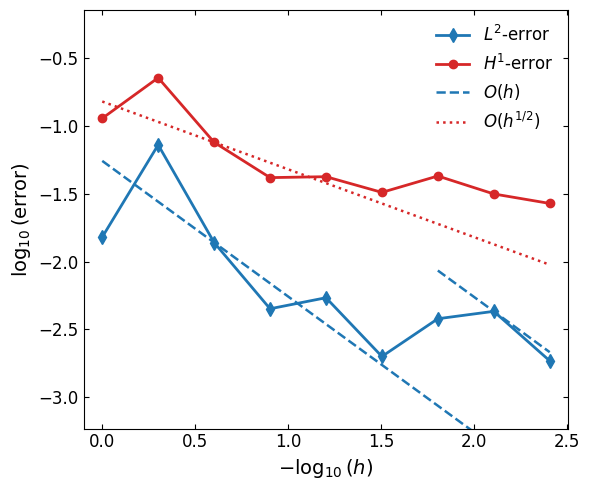

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Data
h = np.array(h_list[:], dtype=float)
L2_err = np.array(rL2s_fem_list[:], dtype=float)
H1_err = np.array(rH1s_list[:], dtype=float)

# Transform axes
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# --- Main curves with color ---
ax.plot(
    x, y_L2, "-d",
    color="tab:blue",
    label=r"$L^2$-error",
    lw=2,
    ms=7,
)

ax.plot(
    x, y_H1, "-o",
    color="tab:red",
    label=r"$H^1$-error",
    lw=2,
    ms=6,
)

# --- Reference lines ---
# O(h): slope = -1
k_ref = 1.0
idx = -2
x0 = x[idx]
y0 = y_L2[idx]
ax.plot(
    x[idx-1:], y0 - k_ref * (x[idx-1:] - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    label=r"$O(h)$"
)

x0 = x[2]
y0 = y_L2[2]
ax.plot(
    x, y0 - k_ref * (x - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    # label=r"$O(h)$"
)

# O(h^{1/2}): slope = -1/2
k_ref = 0.5
x0 = x[2]
y0 = y_H1[2]
ax.plot(
    x, y0 - k_ref * (x - x0),
    ":",
    lw=1.8,
    color="tab:red",
    label=r"$O(h^{1/2})$"
)

# --- Labels & limits ---
ax.set_xlabel(r"$-\log_{10}(h)$", fontsize=14)
ax.set_ylabel(r"$\log_{10}(\text{error})$", fontsize=14)

ax.set_xlim(x.min() - 0.1, x.max() + 0.1)
ax.set_ylim(min(y_L2.min(), y_H1.min()) - 0.5,
            max(y_L2.max(), y_H1.max()) + 0.5)

# No grid
ax.grid(False)

# Ticks
ax.tick_params(direction="in", top=True, right=True, labelsize=12)

# Legend without frame
leg = ax.legend(frameon=False, fontsize=12, loc="best")

plt.tight_layout()
plt.show()


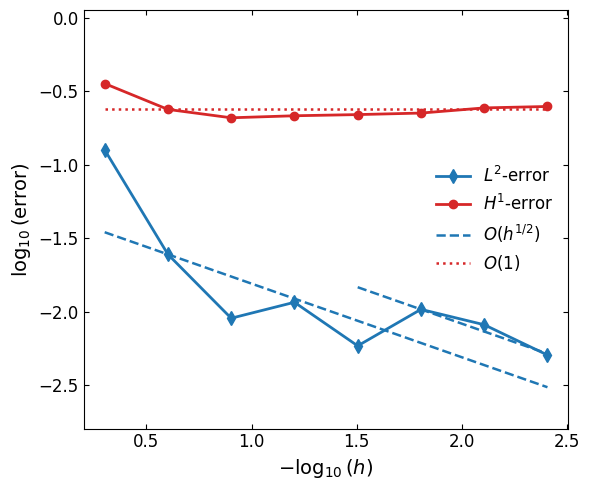

In [14]:
#p_f
import numpy as np
import matplotlib.pyplot as plt

h = np.array(h_list[1:], dtype=float)
L2_err = np.array(rL2s_fem_list_pf[1:], dtype=float)
H1_err = np.array(rH1s_list_pf[1:], dtype=float)

# Transform axes
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# --- Main curves with color ---
ax.plot(
    x, y_L2, "-d",
    color="tab:blue",
    label=r"$L^2$-error",
    lw=2,
    ms=7,
)

ax.plot(
    x, y_H1, "-o",
    color="tab:red",
    label=r"$H^1$-error",
    lw=2,
    ms=6,
)

# --- Reference lines ---
# O(h): slope = -1
k_ref = 0.5
idx = -3
x0 = x[idx]
y0 = y_L2[idx]
ax.plot(
    x[idx-1:], y0 - k_ref * (x[idx-1:] - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    label=r"$O(h^{1/2})$"
)

x0 = x[1]
y0 = y_L2[1]
ax.plot(
    x, y0 - k_ref * (x - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    # label=r"$O(h)$"
)

# O(h^{1/2}): slope = -1/2
k_ref = 0.0
x0 = x[1]
y0 = y_H1[1]
ax.plot(
    x, y0 - k_ref * (x - x0),
    ":",
    lw=1.8,
    color="tab:red",
    label=r"$O(1)$"
)

# --- Labels & limits ---
ax.set_xlabel(r"$-\log_{10}(h)$", fontsize=14)
ax.set_ylabel(r"$\log_{10}(\text{error})$", fontsize=14)

ax.set_xlim(x.min() - 0.1, x.max() + 0.1)
ax.set_ylim(min(y_L2.min(), y_H1.min()) - 0.5,
            max(y_L2.max(), y_H1.max()) + 0.5)

# No grid
ax.grid(False)

# Ticks
ax.tick_params(direction="in", top=True, right=True, labelsize=12)

# Legend without frame
leg = ax.legend(frameon=False, fontsize=12, loc="best")

plt.tight_layout()
plt.show()



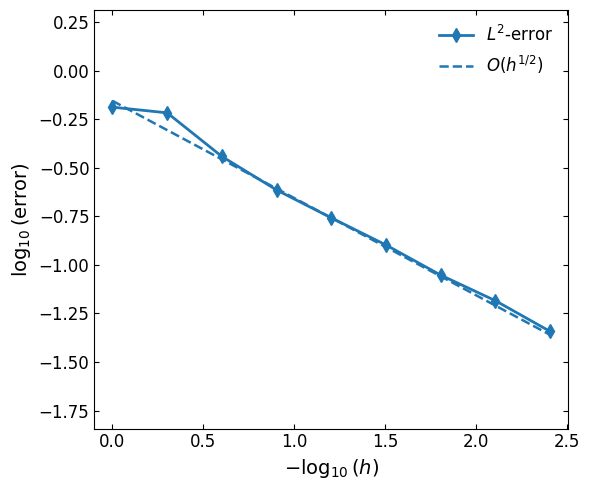

In [16]:
#lmbd
import numpy as np
import matplotlib.pyplot as plt

# Data
h = np.array(h_list[-N_ref:], dtype=float)
L2_err = np.array(rL2s_fem_list_lmbd[-N_ref:], dtype=float)*np.sqrt(h)
# H1_err = np.array(rH1s_list_pf[-N_ref:], dtype=float)

# Transform axes
x = -np.log10(h)
y_L2 = np.log10(L2_err)
# y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# --- Main curves with color ---
ax.plot(
    x, y_L2, "-d",
    color="tab:blue",
    label=r"$L^2$-error",
    lw=2,
    ms=7,
)

# ax.plot(
#     x, y_H1, "-o",
#     color="tab:red",
#     label=r"$H^1$-error",
#     lw=2,
#     ms=6,
# )

# --- Reference lines ---
# O(h): slope = -1
k_ref = 0.5
x0 = x[4]
y0 = y_L2[4]
ax.plot(
    x, y0 - k_ref * (x - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    label=r"$O(h^{1/2})$"
)

# O(h^{1/2}): slope = -1/2
# k_ref = 1
# x0 = x[2]
# y0 = y_H1[2]
# ax.plot(
#     x, y0 - k_ref * (x - x0),
#     ":",
#     lw=1.8,
#     color="tab:red",
#     label=r"$O(h)$"
# )

# --- Labels & limits ---
ax.set_xlabel(r"$-\log_{10}(h)$", fontsize=14)
ax.set_ylabel(r"$\log_{10}(\text{error})$", fontsize=14)

ax.set_xlim(x.min() - 0.1, x.max() + 0.1)
ax.set_ylim(y_L2.min() - 0.5,
            y_L2.max() + 0.5)

# No grid
ax.grid(False)

# Ticks
ax.tick_params(direction="in", top=True, right=True, labelsize=12)

# Legend without frame
leg = ax.legend(frameon=False, fontsize=12, loc="best")

plt.tight_layout()
plt.show()


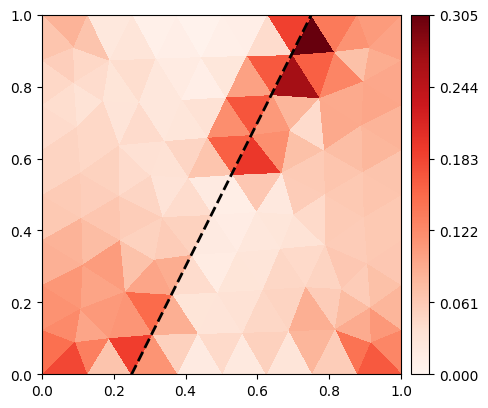

In [3]:
#normal continuity
import ufl
n = ufl.FacetNormal(omega)
u = -k_m * ufl.grad(p_m)

W = fem.functionspace(omega, ("DG", 0))
w = ufl.TestFunction(W)

# Measures: bulk facets and fracture cells
dS_omega = ufl.Measure("dS", domain=omega)   # interior facets of omega
dS_mm = dS_omega(0)
# dx_gamma = dS_omega(Gamma_tag)
ds_omega = ufl.Measure("ds", domain=omega)   # boundary facets of omega
# dx_gamma = ufl.Measure("dx", domain=gamma)   # cells of fracture mesh
dx_gamma = ufl.Measure("ds", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)

# Flux residual:
#   interior faces:     jump(u·n)
#   boundary faces:     u·n
#   fracture:           subtract λ where the fracture cuts the bulk
R_form = (
    # ufl.jump(u, n) * ufl.avg(w) * dS_mm
    abs(ufl.jump(u, n)) * ufl.avg(w) * dS_omega
    # + ufl.dot(u, n) * w * ds_omega
    # - lmbd * w * dx_gamma
    # + lmbd * ufl.avg(w) * dx_gamma
)
# R_form = (
#     ufl.dot(u('+'), n('+')) * w('+') * dS_mm
#   + ufl.dot(u('-'), n('-')) * w('-') * dS_mm
#   + ufl.dot(u, n) * w * ds_omega
# #   - lmbd * ufl.avg(w) * dx_gamma
# )


# IMPORTANT: pass entity_maps here as well
R = fem.form(R_form, entity_maps=entity_maps)
R_vec = fem.petsc.assemble_vector(R)

R = fem.Function(W)
R.x.array[:] = R_vec.array
R.x.scatter_forward()

# Compute cell centroids
# mesh = omega
tdim = omega.topology.dim
omega.topology.create_connectivity(tdim, 0)
cell_to_vertices = omega.topology.connectivity(tdim, 0)
x = omega.geometry.x

# Get local residual values (per cell)
R_local = R.x.array
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])
# vmax_abs = 0.03
xc, yc = x[:, 0], x[:, 1]

c2v_c = omega.topology.connectivity(tdim, 0).array
ct_c = omega.topology.cell_type

if ct_c == mesh.CellType.triangle:
    tris_c = c2v_c.reshape(-1, 3)
elif ct_c == mesh.CellType.quadrilateral:
    quads_c = c2v_c.reshape(-1, 4)
    tris_c = np.column_stack(
        [quads_c[:, [0, 1, 2]], quads_c[:, [0, 2, 3]]]
    ).reshape(-1, 3)
else:
    raise NotImplementedError(f"Unsupported 2D cell type: {ct_c}")
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
tri_c = mtri.Triangulation(xc, yc, tris_c)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig4, ax4 = plt.subplots(figsize=(5, 5))

cont4 = ax4.tripcolor(
    tri_c,
    R_local,
    vmin=0,
    vmax=vmax_abs,
    cmap="Reds"
)

ax4.plot(
    [x_start, x_end],
    [y_start, y_end],
    color='black',
    linewidth=2,
    linestyle='--'
)

ax4.set_aspect("equal")
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

# --- Colorbar with same height as the plot ---
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig4.colorbar(cont4, cax=cax)

ticks = np.linspace(-0, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.3f}" for t in ticks])

plt.show()



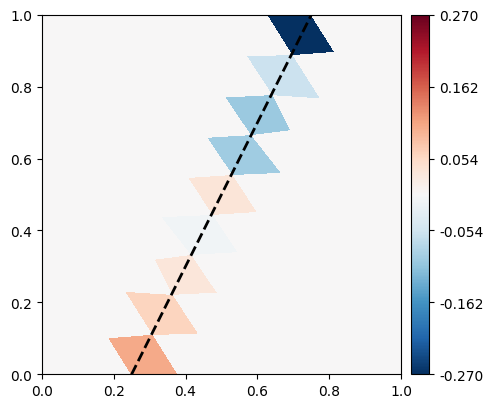

In [4]:
#local conservation using div
import ufl
n = ufl.FacetNormal(omega)
u = -k_m * ufl.grad(p_m)

W = fem.functionspace(omega, ("DG", 0))
w = ufl.TestFunction(W)

# Measures: bulk facets and fracture cells
dS_omega = ufl.Measure("dS", domain=omega)   # interior facets of omega
dS_mm = dS_omega(0)
# dx_gamma = dS_omega(Gamma_tag)
ds_omega = ufl.Measure("ds", domain=omega)   # boundary facets of omega
# dx_gamma = ufl.Measure("dx", domain=gamma)   # cells of fracture mesh
dx_gamma = ufl.Measure("dS", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)

# Flux residual:
#   interior faces:     jump(u·n)
#   boundary faces:     u·n
#   fracture:           subtract λ where the fracture cuts the bulk
R_form = (
    # ufl.jump(u, n) * ufl.avg(w) * dS_mm
    ufl.div(u) * w * ufl.dx
    # ufl.jump(u, n) * ufl.avg(w) * dS_omega
    # + ufl.dot(u, n) * w * ds_omega
    # - lmbd * w * dx_gamma
    - lmbd * ufl.avg(w) * dx_gamma
)
# R_form = (
#     ufl.dot(u('+'), n('+')) * w('+') * dS_mm
#   + ufl.dot(u('-'), n('-')) * w('-') * dS_mm
#   + ufl.dot(u, n) * w * ds_omega
#   - lmbd * ufl.avg(w) * dx_gamma
# )


# IMPORTANT: pass entity_maps here as well
R = fem.form(R_form, entity_maps=entity_maps)
R_vec = fem.petsc.assemble_vector(R)

R = fem.Function(W)
R.x.array[:] = R_vec.array
R.x.scatter_forward()

# Compute cell centroids
# mesh = omega
tdim = omega.topology.dim
omega.topology.create_connectivity(tdim, 0)
cell_to_vertices = omega.topology.connectivity(tdim, 0)
x = omega.geometry.x

# Get local residual values (per cell)
R_local = R.x.array
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])
# vmax_abs = 0.005
xc, yc = x[:, 0], x[:, 1]

c2v_c = omega.topology.connectivity(tdim, 0).array
ct_c = omega.topology.cell_type

if ct_c == mesh.CellType.triangle:
    tris_c = c2v_c.reshape(-1, 3)
elif ct_c == mesh.CellType.quadrilateral:
    quads_c = c2v_c.reshape(-1, 4)
    tris_c = np.column_stack(
        [quads_c[:, [0, 1, 2]], quads_c[:, [0, 2, 3]]]
    ).reshape(-1, 3)
else:
    raise NotImplementedError(f"Unsupported 2D cell type: {ct_c}")
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
tri_c = mtri.Triangulation(xc, yc, tris_c)

fig4, ax4 = plt.subplots(figsize=(5, 5))

# Tripcolor plot
cont4 = ax4.tripcolor(
    tri_c,
    R_local,
    vmin=-vmax_abs,
    vmax=vmax_abs,
    cmap="RdBu_r"
)

ax4.plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')

# Equal aspect and domain limits
ax4.set_aspect("equal")
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

# --- Colorbar with same height as the plot ---
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig4.colorbar(cont4, cax=cax)

ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.3f}" for t in ticks])

plt.show()


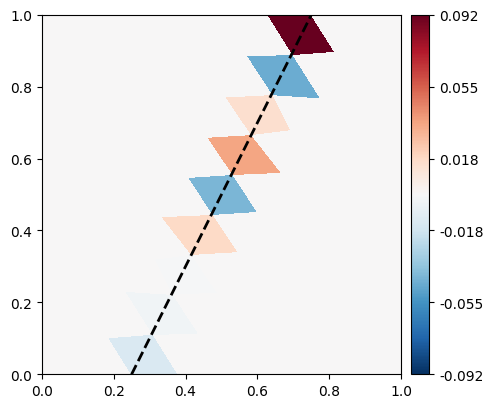

In [5]:
#normal continuity fracture
import ufl
n = ufl.FacetNormal(omega)
u = -k_m * ufl.grad(p_m)

W = fem.functionspace(omega, ("DG", 0))
w = ufl.TestFunction(W)

# Measures: bulk facets and fracture cells
dS_omega = ufl.Measure("dS", domain=omega)   # interior facets of omega
dS_mm = dS_omega(2)
# dx_gamma = dS_omega(Gamma_tag)
ds_omega = ufl.Measure("ds", domain=omega)   # boundary facets of omega
# dx_gamma = ufl.Measure("dx", domain=gamma)   # cells of fracture mesh
dx_gamma = ufl.Measure("dS", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)

# Flux residual:
#   interior faces:     jump(u·n)
#   boundary faces:     u·n
#   fracture:           subtract λ where the fracture cuts the bulk
R_form = (
    # ufl.jump(u, n) * ufl.avg(w) * dx_gamma
    ufl.jump(u, n) * ufl.avg(w) * dx_gamma
    # + ufl.dot(u, n) * w * ds_omega
    # - lmbd * w * dx_gamma
    + lmbd * ufl.avg(w) * dx_gamma
)

# IMPORTANT: pass entity_maps here as well
R = fem.form(R_form, entity_maps=entity_maps)
R_vec = fem.petsc.assemble_vector(R)

R = fem.Function(W)
R.x.array[:] = R_vec.array
R.x.scatter_forward()

# Compute cell centroids
# mesh = omega
tdim = omega.topology.dim
omega.topology.create_connectivity(tdim, 0)
cell_to_vertices = omega.topology.connectivity(tdim, 0)
x = omega.geometry.x

# Get local residual values (per cell)
R_local = R.x.array
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])
# vmax_abs = 0.03
xc, yc = x[:, 0], x[:, 1]

c2v_c = omega.topology.connectivity(tdim, 0).array
ct_c = omega.topology.cell_type

if ct_c == mesh.CellType.triangle:
    tris_c = c2v_c.reshape(-1, 3)
elif ct_c == mesh.CellType.quadrilateral:
    quads_c = c2v_c.reshape(-1, 4)
    tris_c = np.column_stack(
        [quads_c[:, [0, 1, 2]], quads_c[:, [0, 2, 3]]]
    ).reshape(-1, 3)
else:
    raise NotImplementedError(f"Unsupported 2D cell type: {ct_c}")
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
tri_c = mtri.Triangulation(xc, yc, tris_c)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig4, ax4 = plt.subplots(figsize=(5, 5))

cont4 = ax4.tripcolor(
    tri_c,
    R_local,
    vmin=-vmax_abs,
    vmax=vmax_abs,
    cmap="RdBu_r"
)

ax4.plot(
    [x_start, x_end],
    [y_start, y_end],
    color='black',
    linewidth=2,
    linestyle='--'
)

ax4.set_aspect("equal")
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

# --- Colorbar with same height as the plot ---
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig4.colorbar(cont4, cax=cax)

ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.3f}" for t in ticks])

plt.show()



In [6]:
import numpy as np
import ufl
from dolfinx import fem

# --- Spaces & trial/test ---
# DG(0) on bulk (we use it to store facet-averaged jump values)
W = fem.functionspace(omega, ("DG", 0))
w = ufl.TestFunction(W)

# --- flux / normal ---
n = ufl.FacetNormal(omega)
u = -k_m * ufl.grad(p_m)                # UFL expression for flux in bulk

# --- measure restricted to the fracture facets ---
dx_gamma = ufl.Measure(
    "dS",
    domain=omega,
    subdomain_data=facet_markers,
    subdomain_id=Gamma_tag
)

# --- weak extraction of the jump on Gamma ---
# Note: ufl.jump(ufl.dot(u,n)) is a scalar living on interior facets (dS)
jump_on_gamma = ufl.jump(ufl.dot(u, n))

# Build the residual / extraction form: this produces DG(0) dofs containing facet-averaged values
R_jump = (
    jump_on_gamma * ufl.avg(w) * dx_gamma
    # + lmbd * ufl.avg(w) * dx_gamma
)
R_lmbd = (
    # jump_on_gamma * ufl.avg(w) * dx_gamma
    + lmbd * ufl.avg(w) * dx_gamma
)

# IMPORTANT: pass entity_maps so dolfinx knows how to map facet entities (if you have one)
R_jump = fem.form(R_jump, entity_maps=entity_maps)
R_lmbd = fem.form(R_lmbd, entity_maps=entity_maps)

# --- assemble into a PETSc vector ---
R_jump_vec = fem.petsc.assemble_vector(R_jump)
R_lmbd_vec = fem.petsc.assemble_vector(R_lmbd)

# --- put assembled values into a Function on W ---
jump_fun = fem.Function(W, name="jump_on_gamma")
# copy assembled vector into function dofs
# (the assemble_vector result is compatible with the underlying PETSc vector layout,
#  and assigning into jump_fun.x.array follows the pattern you used earlier)
jump_fun.x.array[:] = R_jump_vec[:]
jump_fun.x.scatter_forward()

lmbd_fun = fem.Function(W, name="lmbd_dg")
lmbd_fun.x.array[:] = R_lmbd_vec[:]
lmbd_fun.x.scatter_forward()
# jump_fun now holds the DG(0) coefficients corresponding to the weakly-extracted jump on Gamma.
# You can read them, save, or project to other spaces as needed.
# Example: view local numpy array
print(jump_fun.x.array[:])


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.12259764 0.         0.
 0.         0.         0.         0.         0.         0.
 0.19707479 0.12259764 0.         0.         0.         0.
 0.         0.         0.         0.         0.24287688 0.19707479
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.24287688 0.         0.
 0.         0.27181303 0.28554333 0.         0.         0.
 0.2829946  0.         0.         0.         0.         0.27181303
 0.28554333 0.         0.         0.         0.         0.2829946
 0.         0.         0.         0.         0.         0.
 0.         0.         0.26856691 0.         0.         0.
 0.         0.         0.        

In [7]:
np.set_printoptions(suppress=True)
print(lmbd_fun.x.array[:])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.10138979  0.          0.
  0.          0.          0.          0.          0.          0.
 -0.0599765  -0.10138979  0.          0.          0.          0.
  0.          0.          0.          0.         -0.03257383 -0.0599765
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.03257383  0.          0.
  0.          0.00981704 -0.0341513   0.          0.          0.
  0.09547373  0.          0.          0.          0.          0.00981704
 -0.0341513   0.          0.          0.          0.          0.09547373
  0.          0.          0.          0.          0.          0.
  

In [8]:
lmbd.x.array

array([-1.31648459, -1.94820356, -0.61472135, -0.43413586,  0.75023846,
       -1.84988923,  4.92408417, -1.7193591 ,  3.55884915,  5.14610563])

In [9]:
#local conservation correction
#calc grad p per cell
import numpy as np
from dolfinx import fem, mesh
import ufl

V = V_m
msh = V.mesh

V_g = V_l
g_msh = V_g.mesh
# Your mesh and pressure solution
# msh = mesh_obj
p = p_m

tdim = msh.topology.dim  # should be 3
gdim = msh.geometry.dim  # usually 3 as well

# Vector DG0 space for cell-wise gradients
W = fem.functionspace(msh, ("DG", 0, (gdim,)))

w = ufl.TrialFunction(W)
v = ufl.TestFunction(W)
dx = ufl.dx(domain=msh)

a_grad = ufl.inner(w, v) * dx
L_grad = ufl.inner(ufl.grad(p), v) * dx

grad_p_cell = fem.Function(W)
problem_grad = fem.petsc.LinearProblem(a_grad, L_grad,petsc_options_prefix="grad_p")
grad_p_cell = problem_grad.solve()


In [10]:
# nodal grad (averaging around the node)
msh.topology.create_connectivity(0, tdim)  # vertex -> cell
msh.topology.create_connectivity(tdim, 0)  # cell -> vertex

vertex_to_cell = msh.topology.connectivity(0, tdim)
cell_to_vertex = msh.topology.connectivity(tdim, 0)

num_vertices = msh.topology.index_map(0).size_local

# Will hold nodal gradients
nodal_grad = np.zeros((num_vertices, gdim), dtype=np.float64)
counts = np.zeros(num_vertices, dtype=np.int32)

W_dofmap = W.dofmap
grad_array = grad_p_cell.x.array

num_cells = msh.topology.index_map(tdim).size_local

for cell in range(num_cells):
    cdofs = W_dofmap.cell_dofs(cell)  # length = gdim
    grad_cell = grad_array[cdofs]     # ∇p in this cell, shape (gdim,)

    cell_vertices = cell_to_vertex.links(cell)
    for vtx in cell_vertices:
        nodal_grad[vtx] += grad_cell
        counts[vtx] += 1

# Final nodal (recovered) gradients
for vtx in range(num_vertices):
    if counts[vtx] > 0:
        nodal_grad[vtx] /= counts[vtx]


In [11]:
# required mesh dims (assume set)
# tdim = 2
# fdim = 1
# gdim = 2

# make connectivities
msh.topology.create_connectivity(fdim, tdim)
msh.topology.create_connectivity(tdim, 0)
msh.topology.create_connectivity(fdim, 0)

facet_to_cell   = msh.topology.connectivity(fdim, tdim)  # edge -> cells
cell_to_vertex  = msh.topology.connectivity(tdim, 0)     # cell -> vertices
facet_to_vertex = msh.topology.connectivity(fdim, 0)     # edge -> vertices

num_facets = msh.topology.index_map(fdim).size_local
num_cells  = msh.topology.index_map(tdim).size_local

x = msh.geometry.x[:,0:2]  # (num_vertices, 2)
# nodal_grad: (num_vertices, 2)
# k_m: scalar or 2x2 tensor (or per-face/per-cell if you adapt K_avg selection)

# compute cell centroids (for normal orientation)
cell_cent = np.empty((num_cells, gdim), dtype=np.float64)
for c in range(num_cells):
    verts = np.asarray(cell_to_vertex.links(c), dtype=np.int64)
    if verts.size == 0:
        cell_cent[c, :] = np.nan
    else:
        cell_cent[c, :] = np.mean(x[verts], axis=0)[0:2]

# outputs
facet_flux = np.zeros(num_facets, dtype=np.float64)     # total flux through edge (signed)
face_len   = np.zeros(num_facets, dtype=np.float64)     # edge length
face_norm  = np.zeros((num_facets, gdim), dtype=np.float64)  # unit normal (2D)
face_cent  = np.zeros((num_facets, gdim), dtype=np.float64)  # edge centroid

Gamma_facets = facet_markers.find(2)

for f in range(num_facets):
    if f in Gamma_facets:
        continue
    cells = np.asarray(facet_to_cell.links(f), dtype=np.int64)
    verts = np.asarray(facet_to_vertex.links(f), dtype=np.int64)

    # require exactly 2 vertices for edge
    if verts.size != 2:
        continue

    v0, v1 = verts
    x0, x1 = x[v0], x[v1]

    # edge vector and length
    e = x1 - x0                # vector along edge
    length = np.linalg.norm(e)
    if length == 0.0:
        # degenerate edge
        continue

    # 2D perpendicular (choose convention): perp = [ey, -ex]
    perp = np.array([e[1], -e[0]], dtype=np.float64)
    n_hat = perp / np.linalg.norm(perp)   # unit normal (orientation TBD)

    # edge centroid (midpoint)
    centroid = 0.5 * (x0 + x1)

    # orient normal consistently
    if cells.size == 2:
        c0, c1 = cells[0], cells[1]
        vec_c0_to_c1 = cell_cent[c1] - cell_cent[c0]
        # if n_hat doesn't point from cell0->cell1, flip it
        if np.dot(n_hat, vec_c0_to_c1) < 0:
            n_hat = -n_hat
    elif cells.size == 1:
        c0 = cells[0]
        vec_cell_to_edge = centroid - cell_cent[c0]
        # want outward w.r.t. cell0 (approx): flip if n_hat points inward
        if np.dot(n_hat, vec_cell_to_edge) < 0:
            n_hat = -n_hat
    else:
        # no adjacent cell info on this rank, skip
        continue

    # average nodal gradients on the edge
    grad_face = (nodal_grad[v0] + nodal_grad[v1]) / 2.0

    # Darcy flux vector q = -K ∇p  (K_avg selection can be changed)
    K_avg = k_m
    if np.ndim(K_avg) == 0:
        q_face = -K_avg * grad_face
    else:
        q_face = -np.dot(K_avg, grad_face)

    # normal flux density q · n_hat
    qn_face = np.dot(q_face, n_hat)

    # total flux through the edge = normal flux density * edge length
    F_face = qn_face * length

    # store
    facet_flux[f] = F_face
    face_len[f]   = length
    face_norm[f, :] = n_hat
    face_cent[f, :] = centroid[0:2]

In [12]:
#cell centroid
msh.topology.create_connectivity(tdim, 0)
cell_to_vertex = msh.topology.connectivity(tdim, 0)

num_cells = msh.topology.index_map(tdim).size_local
cell_cent = np.zeros((num_cells, gdim), dtype=np.float64)

for c in range(num_cells):
    verts = cell_to_vertex.links(c)
    cell_cent[c] = np.mean(x[verts], axis=0)[0:2]

In [13]:
lmbd.x.array

array([-1.31648459, -1.94820356, -0.61472135, -0.43413586,  0.75023846,
       -1.84988923,  4.92408417, -1.7193591 ,  3.55884915,  5.14610563])

In [50]:
#calc R manually
tdim = msh.topology.dim
fdim = tdim - 1

# Build connectivities
msh.topology.create_connectivity(tdim, fdim)  # cell -> facet
msh.topology.create_connectivity(fdim, tdim)  # facet -> cell

cell_to_facets = msh.topology.connectivity(tdim, fdim)
facet_to_cells = msh.topology.connectivity(fdim, tdim)

num_cells = msh.topology.index_map(tdim).size_local
R_from_facet = np.zeros(num_cells, dtype=facet_flux.dtype)

# from collections import defaultdict

# cell_to_xgamma = defaultdict(list)

# for i, x_gamma in enumerate(x_g):
#     x_gamma = np.asarray(x_gamma, dtype=np.float64)
#     cid = find_cell(x_gamma)

#     if cid is None:
#         continue

#     cid = int(cid)
#     if 0 <= cid < num_cells:
#         cell_to_xgamma[cid].append(i)   # store index of x_gamma

def integrate_lambda_between_nodes(lmbd_values, coords, index1, index3):
    """
    Integrate lambda ds along a 1D manifold between two node indices
    using the trapezoidal rule.

    Parameters
    ----------
    lmbd_values : (N,) array
        Nodal values, e.g. lmbd.x.array
    coords : (N, dim) array
        Coordinates of the nodes in physical space
    index1, index3 : int
        Start and end node indices (inclusive)

    Returns
    -------
    float
        Approximation of ∫ lambda ds between index1 and index3
    """
    i1 = int(index1)
    i3 = int(index3)

    # Build ordered node index list
    if i1 <= i3:
        nodes = np.arange(i1, i3 + 1)
    else:
        nodes = np.arange(i1, i3 - 1, -1)

    # Extract coordinates and values
    pts = coords[nodes]                      # (n_nodes, dim)
    vals = lmbd_values[nodes]               # (n_nodes,)

    # Segment lengths (ds)
    seg_vecs = pts[1:] - pts[:-1]
    seg_lengths = np.linalg.norm(seg_vecs, axis=1)

    # Trapezoidal integration
    integral = np.sum(0.5 * (vals[:-1] + vals[1:]) * seg_lengths)

    return integral

from dolfinx.mesh import meshtags

def integral_Gamma_from_omega_facets(
    func,
    omega_facet_indices,
    gamma_mesh,
    entity_map,        # instance of EntityMap (dolfinx) as in your paste
    fdim=1,
    tag_value=9,
):
    """
    Integrate `func` on the portion of gamma that corresponds to the given
    omega facet indices, using a dolfinx EntityMap to do the mapping.
    """
    # Normalize and ensure correct dtype/contiguity for the C++ call
    omega_inds = np.ascontiguousarray(np.asarray(omega_facet_indices, dtype=np.int32))

    if omega_inds.size == 0:
        return 0.0

    # Call EntityMap correctly: returns numpy.ndarray(dtype=int32)
    mapped = entity_map.sub_topology_to_topology(omega_inds, True)
    # `mapped` is int32; values < 0 mean "no mapping"

    # Convert to int32 numpy (should already be int32), then select >=0 and unique
    mapped = np.asarray(mapped, dtype=np.int32)
    mask = mapped >= 0
    if not np.any(mask):
        # nothing on this rank
        local_value = 0.0
        return float(gamma_mesh.comm.allreduce(local_value, op=MPI.SUM))

    gamma_selected = np.unique(mapped[mask].astype(np.int32))

    # Tag the selected gamma facets with tag_value
    # values = np.full(gamma_selected.shape, tag_value, dtype=np.int32)
    # facets_tags = mesh.meshtags(gamma_mesh, fdim, gamma_selected, values)

    gamma_cells = np.unique(mapped[mask].astype(np.int32))

    # Create MeshTags tagging those gamma *cells*
    values = np.full(gamma_cells.shape, tag_value, dtype=np.int32)
    cells_tags = mesh.meshtags(gamma_mesh, fdim, gamma_cells, values)

    # Create ds measure restricted to that tag
    # ds_part = ufl.Measure("ds", domain=gamma_mesh, subdomain_data=facets_tags, subdomain_id=tag_value)
    dx_part = ufl.Measure("dx", domain=gamma_mesh, subdomain_data=cells_tags, subdomain_id=tag_value)


    # Assemble integral and reduce across MPI ranks
    local_value = fem.assemble_scalar(fem.form(func * dx_part))
    value = gamma_mesh.comm.allreduce(local_value, op=MPI.SUM)
    return float(value)

for c in range(num_cells):
    facets = cell_to_facets.links(c)
    for f in facets:
        # cells_f = facet_to_cells.links(f)

        # if len(cells_f) == 1:
        #     # Boundary facet: only one cell, global normal is outward
        #     sign = 1.0
        # else:
        #     # Interior facet: first cell sees +F, second sees -F
        #     sign = 1.0 if c == cells_f[0] else -1.0
        has_lmbd = False
        if f in gamma_entities:
            val = integral_Gamma_from_omega_facets(lmbd, [f], gamma, gamma_to_omega)/2
            R_from_facet[c] -= val
            # print(val)
            has_lmbd = True
            # continue
        else:
            n_hat = face_norm[f]
            A_f   = face_len[f]
            F_face = facet_flux[f]
            face_c = face_cent[f]

            # Decide outward direction for THIS cell
            vec_cf = face_c - cell_cent[c]
            sign_cf = np.sign(np.dot(n_hat, vec_cf))
            if sign_cf == 0:
                continue

            # F_out = sign_cf * F_face   # total flux leaving cell c

            R_from_facet[c] += sign_cf * F_face
        if has_lmbd:
            R_wo_lmbd = R_from_facet[c]+val
            print(R_wo_lmbd, R_from_facet[c])



-0.35433284127777775 -0.2529430547499484
-0.41520029237420925 -0.35522379548453503
0.3167580034609599 0.41814778998878926
-0.28231701322990566 -0.24974317939588742
0.40243413207688167 0.4624106289665559
0.34679314039066944 0.3793669742246877
-0.35280919767494723 -0.3626262377982951
-0.3754210786686223 -0.3412697747601773
-0.4551045420087772 -0.5505782760866937
0.3077909516465187 0.2979739115231708
0.3151626647174715 0.3493139686259165
0.3482262152572789 0.2527524811793624
-0.30198896041795154 -0.40151650343450257
-0.30956870881685383 -0.36669683088395366
0.40706132697059405 0.307533783954043
-0.17191670549958388 -0.4422621309680441
0.33432423446124837 0.27719611239414854
0.09798829843856754 -0.1723571270298927


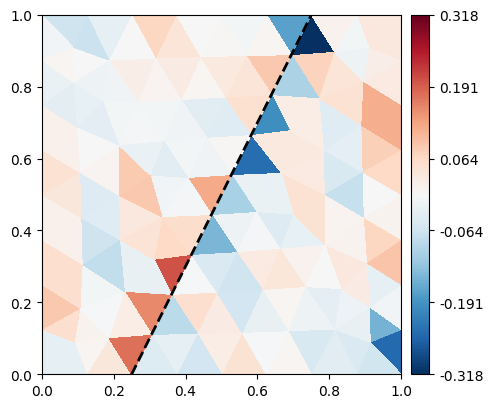

In [51]:
# Get local residual values (per cell)
R_local = R_from_facet
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])
# vmax_abs = 0.3
xc, yc = x[:, 0], x[:, 1]

c2v_c = omega.topology.connectivity(tdim, 0).array
ct_c = omega.topology.cell_type

if ct_c == mesh.CellType.triangle:
    tris_c = c2v_c.reshape(-1, 3)
elif ct_c == mesh.CellType.quadrilateral:
    quads_c = c2v_c.reshape(-1, 4)
    tris_c = np.column_stack(
        [quads_c[:, [0, 1, 2]], quads_c[:, [0, 2, 3]]]
    ).reshape(-1, 3)
else:
    raise NotImplementedError(f"Unsupported 2D cell type: {ct_c}")
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
tri_c = mtri.Triangulation(xc, yc, tris_c)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig4, ax4 = plt.subplots(figsize=(5, 5))

cont4 = ax4.tripcolor(
    tri_c,
    R_local,
    vmin=-vmax_abs,
    vmax=vmax_abs,
    cmap="RdBu_r"
)

ax4.plot(
    [x_start, x_end],
    [y_start, y_end],
    color='black',
    linewidth=2,
    linestyle='--'
)

ax4.set_aspect("equal")
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

# --- Colorbar with same height as the plot ---
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig4.colorbar(cont4, cax=cax)

ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.3f}" for t in ticks])

plt.show()

In [32]:
max(abs(R_from_facet))

np.float64(2.5601585575837977)

In [33]:
R_from_facet

array([-0.24719874, -0.0621594 , -0.15010976, -0.04505578, -0.01194584,
       -0.02470765, -0.03709567, -0.02973048, -0.01927598, -0.05093223,
        0.09032018,  0.02649607, -0.03015361,  0.00726738, -0.01647607,
        0.06930303,  0.03383026,  0.00097862,  0.04620472, -0.00369454,
        0.00534592,  0.01069595,  0.0120832 ,  0.01404229,  0.02328987,
       -0.05739515, -0.02400622,  0.0397579 ,  0.00091283,  0.00929512,
       -0.0272434 ,  0.02644121, -0.0295525 ,  0.51361182,  0.03486592,
       -0.05881429,  0.02749988,  0.06274111, -0.07213745,  0.04554043,
       -0.04014609,  0.05283923,  0.82795515,  0.7332847 ,  0.00634802,
       -0.02960559, -0.06273859, -0.00653979,  0.07682747, -0.05193995,
        0.04948483, -0.022113  ,  0.2705616 ,  1.06833067,  0.02442408,
        0.01183531, -0.02960559, -0.04906557, -0.01498372,  0.115924  ,
       -0.03077936,  0.02793464, -0.02167367,  0.47810585, -0.0229744 ,
       -0.00298568,  0.05450498,  0.08176207, -0.51308952,  0.11

OLD

In [51]:
from dolfinx.fem.petsc import LinearProblem

# Test and trial on gamma (same space as lambda)
mu = ufl.TestFunction(V_l)
q  = ufl.TrialFunction(V_l)

n = ufl.FacetNormal(omega)
u = k_m * ufl.grad(p_m)

jump_flux = ufl.jump(u, n)

# Measures
dx_gamma = ufl.Measure("dx", domain=gamma)  # 1D integration on the submesh

# Mass matrix on gamma (no entity_maps needed, everything lives on gamma)
a_proj = ufl.inner(q, mu) * dx_gamma

# RHS: integrate jump_flux (on Omega facets) against mu (on gamma)
#    -> this mixes meshes, so we use entity_maps=[gamma_to_omega]
dS_Gamma = ufl.Measure("dS", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)
# dS_Gamma = dS_omega(Gamma_tag)
L_proj = jump_flux * ufl.avg(mu) * dS_Gamma

a_form = fem.form(a_proj)
L_form = fem.form(L_proj, entity_maps=[gamma_to_omega])
# L_form = fem.form(L_proj)

# Solve for q in V_l
q_fun = fem.Function(V_l, name="jump_flux_on_gamma")

proj_problem = LinearProblem(
    a_form,
    L_form,
    u=q_fun,
    bcs=[],
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
    petsc_options_prefix = "jump_u"
)

q_fun = proj_problem.solve()


In [52]:
import numpy as np

diff = q_fun.x.array - lmbd.x.array
print("max |jump_flux - lambda|:", np.max(np.abs(diff)))
print("discrete ||jump_flux - lambda||_2:", np.linalg.norm(diff))


max |jump_flux - lambda|: 3.6633210268757193
discrete ||jump_flux - lambda||_2: 5.922608955083979


In [53]:
q_fun.x.array

array([-1.18390968, -1.5179688 , -0.69233223, -0.29570098, -0.0629308 ,
        0.5095839 ,  1.26076314,  1.38311818,  2.25521069,  3.17726995])

In [48]:
lmbd.x.array

array([-1.31648459, -1.94820356, -0.61472135, -0.43413586,  0.75023846,
       -1.84988923,  4.92408417, -1.7193591 ,  3.55884915,  5.14610563])